Execute once cell

In [1]:

from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
#import data_download
import functions
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch
import polars as pl
from torch.nn import functional as F
import torch.optim as optim
import warnings
from torch.optim.lr_scheduler import _LRScheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
#warnings for device
if not torch.cuda.is_available():
    raise Exception('Torch.cuda is not available')
elif device!=torch.device('cuda'):
    warnings.warn('Cuda is not selected as device even if it is available')

In [3]:
dbname='ai_dataset'
dbuser='postgres'
dbpassword='parola'
dbport=5432
dbhost='127.0.0.1'
table_name='tabela'

In [4]:
tickers=["AAPL","MSFT",'SPY','XAUUSD.OANDA','BCO.ICMTRADER']
for i in range(len(tickers)):
    tickers[i]=tickers[i].replace('.','_')
net_functions=functions.Protected_execution


In [5]:
query=net_functions.create_query(tickers[0],table_name)
cursor,conn=net_functions.create_cursor(dbname,dbuser,dbpassword,dbport,dbhost)
data=pl.read_database(query=query,connection=conn)
#data=data.with_columns(pl.col('aapl_adj_close').pct_change().alias('labels'))
#normalize with pandas
#data= data.select((pl.all()-pl.all().mean()) / pl.all().std())

data=data.drop_nulls()
data


aapl_open,aapl_high,aapl_low,aapl_close,aapl_adj_close,aapl_volume
f64,f64,f64,f64,f64,f64
2.585,2.6696,2.5804,2.2722,2.2722,8.0723443e8
2.6832,2.7136,2.6607,2.2789,2.2789,6.196036e8
2.6725,2.675,2.6339,2.2609,2.2609,4.494224e8
2.6875,2.7393,2.6625,2.3193,2.3193,7.044576e8
2.7404,2.7571,2.705,2.3118,2.3118,6.7504077e8
…,…,…,…,…,…
195.18,195.41,192.97,193.6,193.6,3.71228e7
193.61,193.89,192.83,193.05,193.05,2.89193e7
192.49,193.5,191.09,193.15,193.15,4.80877e7


In [6]:
#get data from polars
#labels=data['labels']
train_data=data['aapl_high']
#make polars data into torch tensors
train_data=torch.tensor(train_data)

batch_size=32

In [7]:
#shorten the tensor
shortened_tensor=net_functions.tensor_shortner(train_data, batch_size)
#create batches of 32
image_tensor=net_functions.image_builder(shortened_tensor,batch_size=batch_size)
#create tensor
labels=net_functions.change(image_tensor, batch_size)
#cut the last image from data variable to adjust for change function
image_tensor=image_tensor[:-1]


In [8]:
labels=[x+20 for x in labels]
max(labels)

40

In [9]:
#make labels and data into tensors
labels=torch.tensor(labels,dtype=torch.int32)

labels=labels.type(torch.LongTensor)
image_tensor=torch.tensor(image_tensor)

image_tensor=net_functions.make_tensor(data,image_tensor,tickers[0])


#normalize data tensor
#image_tensor=net_functions.fit_to_range_tensor(image_tensor)


#move them to gpu
labels=labels.to(device)
image_tensor=image_tensor.to(device)



In [10]:
def min_max_normalize(tensor):
    for c in range(tensor.size(1)):
        channel_min = tensor[:, c, :].min()
        channel_max = tensor[:, c, :].max()
        tensor[:, c, :] = (tensor[:, c, :] - channel_min) / (channel_max - channel_min)
    return tensor

print(image_tensor.shape)
image_tensor = min_max_normalize(image_tensor)  # Use clone() to avoid modifying the original tensor



torch.Size([4478, 4, 32])


In [11]:
#split data with sklearn
train_dataset,test_dataset,train_labels,test_labels=train_test_split(image_tensor,labels,test_size=.1)



In [20]:
train_dataset.dtype

torch.float32

In [12]:
class SGDRScheduler(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1):
        self.T_0 = T_0
        self.T_cur = 0
        self.T_mult = T_mult
        self.eta_min = eta_min
        super(SGDRScheduler, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == 0:
            self.T_i = self.T_0
        else:
            self.T_i = self.T_0 * (self.T_mult ** (self.last_epoch // self.T_0))
        
        cos_inner = np.pi * (self.T_cur % self.T_i)
        cos_inner /= self.T_i
        cos_out = np.cos(cos_inner) + 1
        return [self.eta_min + (base_lr - self.eta_min) / 2 * cos_out for base_lr in self.base_lrs]
    
    def step(self, epoch=None):
        if epoch is not None:
            self.T_cur = epoch % self.T_i
        super(SGDRScheduler, self).step(epoch)
        if epoch is not None and epoch % self.T_i == 0:
            self.T_cur = 0


In [16]:



def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self, printtoggle=False):
        super().__init__()

        # Input layer for 1D data of size 32
        self.conv1a = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=2)
        self.conv2a = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride=1, padding=2)

        self.conv1b = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=2, stride=1, padding=2)
        self.conv2b = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=2, stride=1, padding=2)

        self.conv1c = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=2)
        self.conv2c = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=2)

        self.conv1d = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=4, stride=1, padding=2)
        self.conv2d = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=4, stride=1, padding=2)

        self.conv1e = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.conv2e = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)

        self.conv1f = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=6, stride=1, padding=2)
        self.conv2f = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=6, stride=1, padding=2)
        
        self.pool=nn.MaxPool1d(kernel_size=2, stride=1)
        # fully-connected layers
        self.fc1 = nn.Linear(832, 460) 
        self.fc2 = nn.Linear(460, 280)
        #self.fc3 = nn.Linear(416, 208)
        self.fc4 = nn.Linear(280, 128)  # Assuming 10 output classes
        self.fc5 = nn.Linear(128, 41)  # Assuming 10 output classes

        # toggle for printing out tensor sizes during forward prop
        #self.print = printtoggle
        self.dropout = nn.Dropout(p=0.25)
        # Use GPU if available
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.to(self.device)  # Move the model to the chosen device

    # forward pass
    def forward(self, x):
        # Move input to device
        #x = x.to(self.device)
        x_context=x[0]
        x_a=x
        x_b=x
        x_c=x
        x_d=x
        x_e=x
        x_f=x
        
        #print(f' inainte de conv: {x.shape}')

        #next window
        # Convolution -> relu
        x_a = F.relu(self.conv1a(x))
        x_a = self.pool(x)
        x_a = self.dropout(x)
        
        # Convolution -> relu
        x_a = F.relu(self.conv2a(x))
        x_a = self.pool(x)
        x_a = self.dropout(x)
        '''####################################################'''

        
        #next window
        # Convolution -> relu
        x_b = F.relu(self.conv1b(x))
        x_b = self.pool(x)
        x_b = self.dropout(x)
        
        # Convolution -> relu
        x_b = F.relu(self.conv2b(x))
        x_b = self.pool(x)
        x_b = self.dropout(x)


        
        '''####################################################'''
        #next window
        # Convolution -> relu
        x_c = F.relu(self.conv1c(x))
        x_c = self.pool(x)
        x_c = self.dropout(x)
        
        # Convolution -> relu
        x_c = F.relu(self.conv2c(x))
        x_c = self.pool(x)
        x_c = self.dropout(x)


        
        '''####################################################'''
        #next window
        # Convolution -> relu
        x_d = F.relu(self.conv1d(x))
        x_d = self.pool(x)
        x_d = self.dropout(x)
        
        # Convolution -> relu
        x_d = F.relu(self.conv2d(x))
        x_d = self.pool(x)
        x_d = self.dropout(x)


        
        '''####################################################'''
        #next window
        # Convolution -> relu
        x_e = F.relu(self.conv1e(x))
        x_e = self.pool(x)
        x_e = self.dropout(x)
        
        # Convolution -> relu
        x_e = F.relu(self.conv2e(x))
        x_e = self.pool(x)
        x_e = self.dropout(x)


        
        '''####################################################'''
        #next window
        # Convolution -> relu
        x_f = F.relu(self.conv1f(x))
        x_f = self.pool(x)
        x_f = self.dropout(x)
        
        # Convolution -> relu
        x_f = F.relu(self.conv2f(x))
        x_f = self.pool(x)
        x_f = self.dropout(x)


        
        '''####################################################'''
        x=torch.cat([x_a,x_b,x_c,x_d,x_e,x_f],0)
        x = x.view(-1)  # Flatten the tensor
        x = torch.cat([x_context,x])
        # Fully connected layer

        
        x=torch.cat([x_context,x])
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        #x = F.relu(self.fc3(x))
        #x = self.dropout(x)

        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        x = self.fc5(x)
        return x





  # create the model instance
  net = mnistNet(printtoggle)
  
  # loss function (assuming classification task)
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = optim.SGD(net.parameters(),lr=.01)
  T_0=50
  scheduler=SGDRScheduler(optimizer, T_0=T_0,T_mult=2,eta_min=0.005)  

  return net,lossfun,optimizer


In [17]:
def function2trainTheModel(train_dataset, train_labels, test_dataset, test_labels,numepochs = 50):

  # number of epochs
  
  
  # create a new model
  net, lossfun, optimizer = createTheMNISTNet()

  # initialize losses
  losses = torch.zeros(numepochs).to(device)
  trainAcc = []
  testAcc = []
  z=0
  # loop over epochs
  for epochi in range(numepochs):
    z+=1
    # initialize batch losses and accuracies
    epochLoss = 0.0
    epochAcc = 0.0
    print(z)
    # loop over training data batches
    for i in range(train_dataset.size()[0]):
      X=train_dataset[i]
      y=train_labels[i]
      
      #X = X.unsqueeze(1)  # Add a singleton dimension for the channel axis
     
      # forward pass and loss
      yHat = net(X)
        
      loss = lossfun(yHat, y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accumulate batch loss
      epochLoss += loss.item()

      # compute accuracy
      matches = torch.argmax(yHat, axis=0) == y
      accuracyPct = 100 * torch.mean(matches.float())
      epochAcc += accuracyPct.item()

    # end of batch loop

    # average loss and accuracy for the epoch
    epochLoss /= train_dataset.size()[0]
    epochAcc /= train_dataset.size()[0]

    # append to lists
    losses[epochi] = epochLoss
    trainAcc.append(epochAcc)

    # test accuracy (evaluate on test set)
    test_epochAcc = 0
    total_correct = 0
    total_samples = 0
    
    '''with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)  # Move data to device
            yHat_test = net(X_test)
            matches_test = torch.argmax(yHat_test, dim=1) == y_test
            total_correct += matches_test.sum().item()
            total_samples += y_test.size(0)
    
    test_epochAcc = 100 * total_correct / total_samples
    testAcc.append(test_epochAcc)

     ''' 
    test_epochAcc = 0.0
    with torch.no_grad():
      for i_test in range(test_dataset.size()[0]):
        X_test=test_dataset[i_test]
        y_test=test_labels[i_test]
        yHat_test=net(X_test)
        matches_test = torch.argmax(yHat_test, axis=0) == y_test
        accuracyPct_test = 100 * torch.mean(matches_test.float())
        test_epochAcc += accuracyPct_test.item()
    test_epochAcc /= train_dataset.size()[0]
    testAcc.append(test_epochAcc)

  # end epochs loop

  # function output
  return trainAcc, testAcc, losses, net



In [21]:

trainAcc,testAcc,losses,net = function2trainTheModel(train_dataset, train_labels, test_dataset, test_labels,numepochs = 250)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


In [24]:
testAcc

[0.4466501240694789,
 0.6203473945409429,
 0.794044665012407,
 0.7692307692307693,
 0.6947890818858561,
 0.6947890818858561,
 0.6699751861042184,
 0.6947890818858561,
 0.6947890818858561,
 0.6947890818858561,
 0.8436724565756824,
 0.8933002481389578,
 0.8684863523573201,
 0.9925558312655087,
 1.066997518610422,
 0.967741935483871,
 1.066997518610422,
 0.794044665012407,
 1.1662531017369726,
 1.0173697270471465,
 1.1910669975186103,
 1.0173697270471465,
 1.215880893300248,
 0.9925558312655087,
 1.0918114143920596,
 0.967741935483871,
 1.0918114143920596,
 1.0421836228287842,
 1.066997518610422,
 0.967741935483871,
 1.1910669975186103,
 1.2903225806451613,
 1.0918114143920596,
 0.7444168734491315,
 1.0918114143920596,
 1.315136476426799,
 1.0173697270471465,
 0.9181141439205955,
 0.967741935483871,
 1.1910669975186103,
 1.5136476426799008,
 1.1414392059553349,
 1.1166253101736974,
 0.9925558312655087,
 1.1166253101736974,
 0.9181141439205955,
 1.0421836228287842,
 0.9925558312655087,
 1.

In [26]:
nploss=losses.to("cpu")
nploss=nploss.cpu()
losses=losses.cpu().numpy()
plt.plot(losses)

plt.title('losses over time')


AttributeError: 'numpy.ndarray' object has no attribute 'to'

Text(0.5, 1.0, 'losses over time')

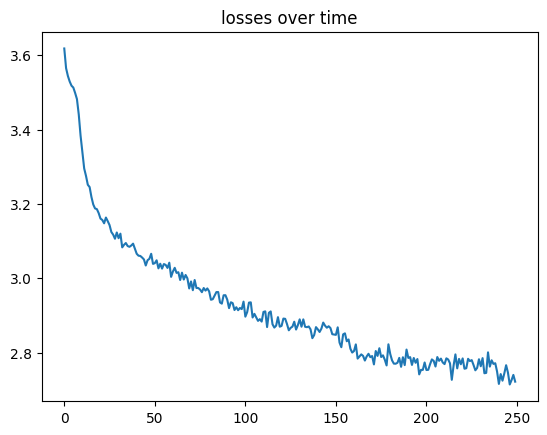

In [28]:
plt.plot(losses)

plt.title('losses over time')


In [ ]:
def test(model, device, test_dataset, test_labels, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for i_test in range(test_dataset.size()[0]):
        X_test=test_dataset[i_test]
        y_test=test_labels[i_test]
        X_test, y_test = X_test.to(device), y_test.to(device)
        X_test=X_test.unsqueeze(1)
        output = model(X_test)
        test_loss += criterion(output, y_test).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataset)
    accuracy = 100. * correct / len(test_dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataset)} '
          f'({accuracy:.0f}%)\n')
    print(nploss)

In [ ]:
test(net,device,test_dataset, test_labels,nn.CrossEntropyLoss())